In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
import os
import warnings
warnings.filterwarnings("ignore")

# Keras 가 Tensorflow 를 벡엔드로 사용할 수 있도록 설정합니다.
os.environ["KERAS_BACKEND"] = "tensorflow"

# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정합니다.
seed = 2019
np.random.seed(seed)
tf.set_random_seed(seed)

# 데이터셋 로드
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom = pd.read_csv(url, header=None, delim_whitespace=True)
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_csv(url, header=None, usecols=[0], squeeze=True, delim_whitespace=True)
# delim_whitespace = True : 빈 공간(' ')을 구분자로 인식하고 데이터 읽어옴
# squeeze 만약 컬럼 하나만 읽어오면 데이터 구조를 Series로 읽어옴

print('The dataset has {} observations/rows and {} variables/columns.'.format(secom.shape[0], secom.shape[1]))
print('The majority class has {} observations, minority class {}.'.format(y[y == -1].size, y[y == 1].size))
print('The dataset is imbalanced. The ratio of majority class to minority class is {%.2f}:1.' % (float(y[y == -1].size/y[y == 1].size)))

The dataset has 1567 observations/rows and 590 variables/columns.
The majority class has 1463 observations, minority class 104.
The dataset is imbalanced. The ratio of majority class to minority class is {14.07}:1.


In [2]:

m = list(map(lambda x: sum(secom[x].isnull()), range(secom.shape[1])))

m_200thresh = filter(lambda i: (m[i] > 200), range(secom.shape[1]))

secom_drop_200thresh = secom.dropna(subset=list(m_200thresh), axis=1)
print('No. of columns after dropping columns with more than 200 missing entries: {}'.format(secom_drop_200thresh.shape[1]))

dropthese = [i for i in range(590) if secom_drop_200thresh[i].std() == 0]
secom_categorical = secom_drop_200thresh.drop(dropthese, axis = 1)
secom_categorical = secom_categorical.drop(filtered_columns, 1)

print(secom_categorical.shape)
secom_categorical.head()

print('There are {} columns which have identical values recorded. We will drop these.'.format(len(dropthese)))
print('The data set now has {} columns.'.format(secom_categorical.shape[1]))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(secom_categorical, y, test_size = 0.2)
# ndarray
print(X_train.shape) # (1253, 474)
print(X_test.shape) # (314, 474)
print(y_train.shape) # (1253,)
print(y_test.shape) # (314,)

# 결측치 파악을 위한 히스토그램 출력
df_X_train = pd.DataFrame(X_train)
feature_names = df_X_train.columns
m = list((map(lambda i: sum(df_X_train[i].isnull()), feature_names)))
plt.hist(m)
plt.title("Distribution of missing values")
plt.xlabel("No. of missing values in a column")
plt.ylabel("Columns(count)")
plt.show()

# 결측치 파악을 위한 문구 출력
df_X_train = pd.DataFrame(X_train)

criteriaList = [400, 500, 600, 700, 800, 900, 1000]

for criteria in criteriaList :
    columns_filtered = list(filter(lambda i: sum(df_X_train[i].isnull()) > criteria, df_X_train.columns))
    print('The number of columns with more than {:>4d} missing values(about {}%): {:>2d}'.format(criteria, int((criteria/1253)*100), len(columns_filtered)))

# fill_NaN_by_Gaussian 함수를 적용하기 위해 데이터 형변환 (ndarray -> DataFrame)
df_X_train = pd.DataFrame(X_train)
df_X_test = pd.DataFrame(X_test)
print(df_X_train.shape)
print(df_X_test.shape)


def fill_NaN_by_Gaussian(df_X_train, df_X_test):
    """결측치를 해당 열의 가우시안 분포를 따르는 난수로 대체하는 함수이다.
       단, test셋의 각 열은 train셋의 각 열의 가우시안 분포를 따른다고 가정한다.
       따라서, test셋은 train셋의 mean, std를 사용한다.                      """

    for column in df_X_train.columns.values:
        mean = df_X_train[column].mean()
        std = df_X_train[column].std()

        X_train_NaN_size = sum(df_X_train[column].isnull())
        X_test_NaN_size = sum(df_X_test[column].isnull())

        df_X_train.loc[df_X_train[column].isnull(), column] = np.random.normal(mean, std, size=X_train_NaN_size)
        df_X_test.loc[df_X_test[column].isnull(), column] = np.random.normal(mean, std, size=X_test_NaN_size)

    return (df_X_train, df_X_test)


# main
df_X_train, df_X_test = fill_NaN_by_Gaussian(df_X_train, df_X_test)
print(df_X_train.shape)
print(df_X_test.shape)

# 표준 정규 분포로 Normalization
# train 데이터의 각 열에 적용한 평균과 표준편차를 test 데이터의 각 열에 동일하게 적용함
def standardProcess(df_X_train, df_X_test):
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    std_scale_parameters = scaler.fit(df_X_train.values) # train 데이터의 평균과 표준편차로 파라미터를 피팅한 후 저장, test 데이터에도 똑같은 파라미터를 적용하기 위함

    scaled_X_train= std_scale_parameters.transform(df_X_train) # [n_samples, n_features]의 크기로 반환, [1253,474]
    scaled_X_test= std_scale_parameters.transform(df_X_test) # [n_samples, n_features]의 크기로 반환, [314,474]

    scaled_df_X_train = pd.DataFrame(scaled_X_train, index = df_X_train.index, columns = df_X_train.columns) # 데이터 프레임으로 변환, 기존의 index, columns 사용
    scaled_df_X_test = pd.DataFrame(scaled_X_test, index =df_X_test.index, columns = df_X_test.columns) # 데이터 프레임으로 변환, 기존의 index, columns 사용

    return scaled_df_X_train, scaled_df_X_test

def minmaxProcess(df_X_train, df_X_test):
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    mms_scale_params = scaler.fit(df_X_train.values)

    scaled_X_train = mms_scale_params.transform(df_X_train)
    scaled_X_test = mms_scale_params.transform(df_X_test)

    scaled_df_X_train = pd.DataFrame(scaled_X_train, index= df_X_train.index, columns= df_X_train.columns)
    scaled_df_X_test = pd.DataFrame(scaled_X_test, index= df_X_test.index, columns= df_X_test.columns)

    return scaled_df_X_train, scaled_df_X_test

select = input("사용할 Scaler 함수를 입력 / mms = MinMaxScaler / std = StandardScaler\n")
if select == "std":
    print("선택한 함수는 Standard Scaler")
    scaled_df_X_train, scaled_df_X_test = standardProcess(df_X_train,df_X_test)
elif select == "mms":
    print("선택한 함수는 MinMaxScaler")
    scaled_df_X_train, scaled_df_X_test = minmaxProcess(df_X_train, df_X_test)
else:
    print("다른 값 입력으로 default로 Standard Scaler를 사용합니다.")
    scaled_df_X_train, scaled_df_X_test = standardProcess(df_X_train, df_X_test)

from sklearn.decomposition import PCA
# PCA 인스턴스 객체를 생성.
pca = PCA(0.8)

# 생성된 PCA 인스턴스 객체에 scaled_df_X_train를 Fitting.
# 주의: fit은 오직 scaled_df_X_train에만 적용.
# 동일한 파라미터를 scaled_df_X_test에 적용하기 위함.
pca.fit(scaled_df_X_train)

# transform하게 되면  ndarray로 반환하기 때문에 별도의 DataFrame 형변환 필요.
X_train_after_PCA = pca.transform(scaled_df_X_train)
X_test_after_PCA = pca.transform(scaled_df_X_test)

# PCA 수행 후의 X_train을 DataFrame으로 형변환
df_X_train_after_PCA = pd.DataFrame(data=X_train_after_PCA, index=scaled_df_X_train.index)
# PCA 수행 후의 X_test을 DataFrame으로 형변환
df_X_test_after_PCA = pd.DataFrame(data=X_test_after_PCA, index=scaled_df_X_test.index)

print(df_X_train_after_PCA.shape[0],df_X_train_after_PCA.shape[1])

# 아래부턴 CGAN 코드

from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

# latent space dimension
latent_dim = 100
secom_dim = df_X_train_after_PCA.shape[1]
init = initializers.RandomNormal(stddev=0.02)
# Generator network
generator = Sequential()
# Input layer and hidden layer 1
generator.add(Dense(76, input_shape=(latent_dim,),
                    kernel_initializer=init))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
# Hidden layer 2
generator.add(Dense(152))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
# Hidden layer 3
generator.add(Dense(304))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
# Output layer
generator.add(Dense(secom_dim, activation='tanh'))

# Embedding condition in input layer
num_classes = 2
# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)
# latent space
z = Input(shape=(latent_dim,))
# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

secom_generate = generator(input_generator)
# Generator with condition input
generator = Model([z, label], secom_generate)

# Discriminator network
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(76, input_shape=(secom_dim,),
                        kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Hidden layer 2
discriminator.add(Dense(152))
discriminator.add(LeakyReLU(0.2))

# Hidden layer 3
discriminator.add(Dense(304))
discriminator.add(LeakyReLU(0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, secom_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

img_d = Input(shape=(secom_dim,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

# Optimizer
opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(opt, loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(opt, loss='binary_crossentropy',
            metrics=['binary_accuracy'])

epochs = 1000
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []
np_X_train = df_X_train_after_PCA.as_matrix()
np_y_train = pd.DataFrame(y_train).as_matrix()

No. of columns after dropping columns with more than 200 missing entries: 520


KeyError: 7

In [2]:
fake_y_train_df = []
for i in range(100):
    fake_y_train_df.append(2)
fake_y_train_df = pd.DataFrame(fake_y_train_df)
tsneEmbedded = TSNE(n_components=2,perplexity=30,learning_rate=200)

epoch = 1/1000, d_loss=0.692, g_loss=0.701                                                                                                                    


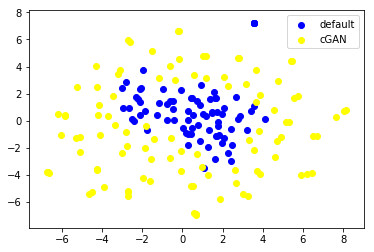

epoch = 2/1000, d_loss=0.689, g_loss=0.717                                                                                                                    
epoch = 3/1000, d_loss=0.681, g_loss=0.753                                                                                                                    
epoch = 4/1000, d_loss=0.665, g_loss=0.818                                                                                                                    
epoch = 5/1000, d_loss=0.652, g_loss=0.904                                                                                                                    
epoch = 6/1000, d_loss=0.613, g_loss=1.121                                                                                                                                                                                                                        
epoch = 7/1000, d_loss=0.580, g_loss=1.160                                                               

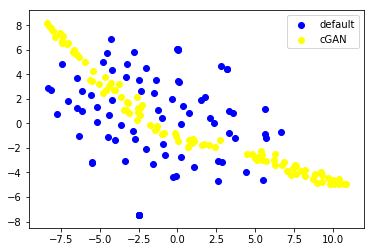

epoch = 27/1000, d_loss=0.670, g_loss=0.857                                                                                                                    
epoch = 28/1000, d_loss=0.704, g_loss=0.757                                                                                                                                                                                                                       
epoch = 29/1000, d_loss=0.633, g_loss=0.901                                                                                                                    
epoch = 30/1000, d_loss=0.668, g_loss=1.356                                                                                                                    
epoch = 31/1000, d_loss=0.640, g_loss=0.953                                                                                                                    
epoch = 32/1000, d_loss=0.698, g_loss=0.828                                                          

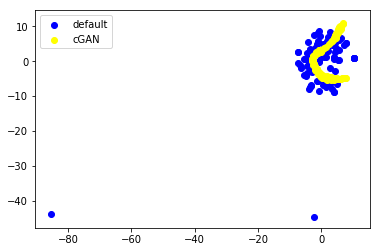

epoch = 52/1000, d_loss=0.631, g_loss=0.954                                                                                                                    
epoch = 53/1000, d_loss=0.688, g_loss=0.772                                                                                                                    
epoch = 54/1000, d_loss=0.640, g_loss=0.848                                                                                                                    
epoch = 55/1000, d_loss=0.638, g_loss=0.762                                                                                                                    
epoch = 56/1000, d_loss=0.618, g_loss=1.159                                                                                                                    
epoch = 57/1000, d_loss=0.615, g_loss=1.569                                                                                                                    
epoch = 58/1000, d_loss=0.611, g_loss=0.

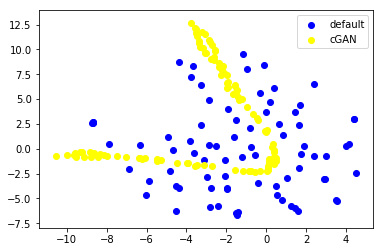

epoch = 77/1000, d_loss=0.646, g_loss=1.034                                                                                                                    
epoch = 78/1000, d_loss=0.589, g_loss=0.848                                                                                                                    
epoch = 79/1000, d_loss=0.628, g_loss=0.796                                                                                                                    
epoch = 80/1000, d_loss=0.594, g_loss=1.201                                                                                                                    
epoch = 81/1000, d_loss=0.632, g_loss=0.879                                                                                                                    
epoch = 82/1000, d_loss=0.696, g_loss=0.840                                                                                                                    
epoch = 83/1000, d_loss=0.685, g_loss=0.

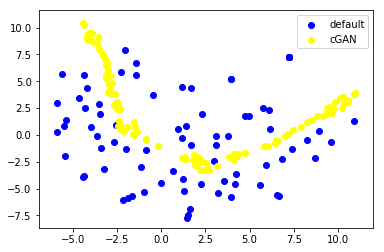

epoch = 102/1000, d_loss=0.661, g_loss=0.907                                                                                                                    
epoch = 103/1000, d_loss=0.666, g_loss=0.997                                                                                                                    
epoch = 104/1000, d_loss=0.671, g_loss=1.073                                                                                                                    
epoch = 105/1000, d_loss=0.637, g_loss=0.982                                                                                                                    
epoch = 106/1000, d_loss=0.631, g_loss=1.154                                                                                                                    
epoch = 107/1000, d_loss=0.640, g_loss=1.627                                                                                                                    
epoch = 108/1000, d_loss=0.728, g_

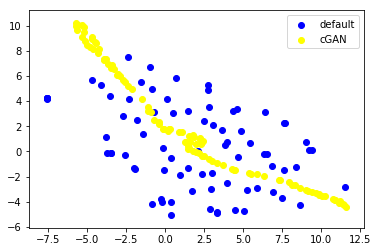

epoch = 127/1000, d_loss=0.632, g_loss=1.363                                                                                                                    
epoch = 128/1000, d_loss=0.631, g_loss=1.370                                                                                                                    
epoch = 129/1000, d_loss=0.675, g_loss=0.996                                                                                                                    
epoch = 130/1000, d_loss=0.662, g_loss=0.856                                                                                                                    
epoch = 131/1000, d_loss=0.622, g_loss=1.664                                                                                                                    
epoch = 132/1000, d_loss=0.653, g_loss=0.964                                                                                                                    
epoch = 133/1000, d_loss=0.671, g_

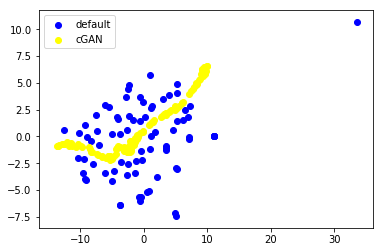

epoch = 152/1000, d_loss=0.637, g_loss=0.760                                                                                                                    
epoch = 153/1000, d_loss=0.612, g_loss=0.934                                                                                                                    
epoch = 154/1000, d_loss=0.639, g_loss=0.843                                                                                                                    
epoch = 155/1000, d_loss=0.637, g_loss=0.855                                                                                                                    
epoch = 156/1000, d_loss=0.626, g_loss=0.914                                                                                                                    
epoch = 157/1000, d_loss=0.637, g_loss=0.797                                                                                                                    
epoch = 158/1000, d_loss=0.576, g_

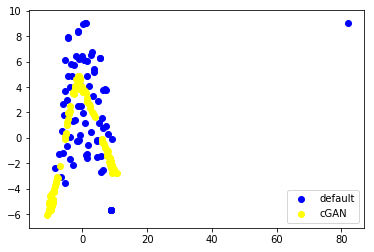

epoch = 177/1000, d_loss=0.583, g_loss=0.715                                                                                                                    
epoch = 178/1000, d_loss=0.609, g_loss=1.581                                                                                                                    
epoch = 179/1000, d_loss=0.653, g_loss=0.855                                                                                                                                                                                                                        
epoch = 180/1000, d_loss=0.609, g_loss=0.846                                                                                                                    
epoch = 181/1000, d_loss=0.663, g_loss=0.835                                                                                                                    
epoch = 182/1000, d_loss=0.638, g_loss=0.791                                                   

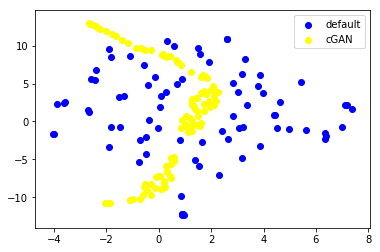

epoch = 202/1000, d_loss=0.683, g_loss=0.832                                                                                                                    
epoch = 203/1000, d_loss=0.686, g_loss=0.746                                                                                                                    
epoch = 204/1000, d_loss=0.628, g_loss=0.809                                                                                                                    
epoch = 205/1000, d_loss=0.580, g_loss=0.861                                                                                                                    
epoch = 206/1000, d_loss=0.597, g_loss=0.848                                                                                                                    
epoch = 207/1000, d_loss=0.649, g_loss=0.801                                                                                                                    
epoch = 208/1000, d_loss=0.653, g_

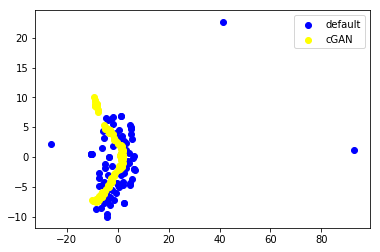

epoch = 227/1000, d_loss=0.633, g_loss=0.784                                                                                                                    
epoch = 228/1000, d_loss=0.610, g_loss=0.780                                                                                                                    
epoch = 229/1000, d_loss=0.544, g_loss=0.675                                                                                                                    
epoch = 230/1000, d_loss=0.603, g_loss=0.818                                                                                                                    
epoch = 231/1000, d_loss=0.653, g_loss=1.068                                                                                                                    
epoch = 232/1000, d_loss=0.606, g_loss=0.683                                                                                                                                                       

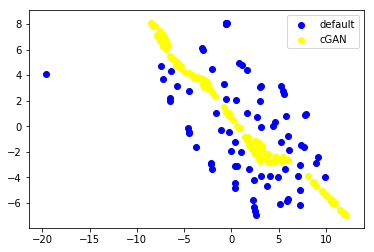

epoch = 252/1000, d_loss=0.656, g_loss=1.616                                                                                                                    
epoch = 253/1000, d_loss=0.582, g_loss=1.422                                                                                                                    
epoch = 254/1000, d_loss=0.596, g_loss=1.081                                                                                                                    
epoch = 255/1000, d_loss=0.608, g_loss=1.860                                                                                                                    
epoch = 256/1000, d_loss=0.602, g_loss=2.332                                                                                                                    
epoch = 257/1000, d_loss=0.637, g_loss=1.036                                                                                                                    
epoch = 258/1000, d_loss=0.622, g_

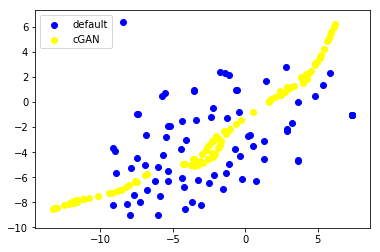

epoch = 277/1000, d_loss=0.631, g_loss=1.017                                                                                                                    
epoch = 278/1000, d_loss=0.563, g_loss=2.174                                                                                                                    
epoch = 279/1000, d_loss=0.636, g_loss=1.059                                                                                                                    
epoch = 280/1000, d_loss=0.546, g_loss=1.066                                                                                                                    
epoch = 281/1000, d_loss=0.590, g_loss=0.849                                                                                                                    
epoch = 282/1000, d_loss=0.543, g_loss=0.669                                                                                                                    
epoch = 283/1000, d_loss=0.613, g_

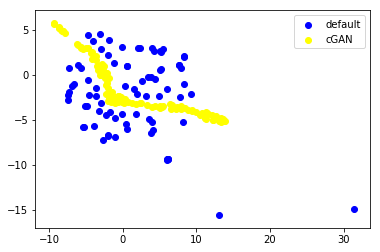

epoch = 302/1000, d_loss=0.628, g_loss=1.104                                                                                                                    
epoch = 303/1000, d_loss=0.533, g_loss=1.169                                                                                                                                                                                                                        
epoch = 304/1000, d_loss=0.585, g_loss=1.022                                                                                                                    
epoch = 305/1000, d_loss=0.578, g_loss=1.203                                                                                                                    
epoch = 306/1000, d_loss=0.545, g_loss=1.108                                                                                                                    
epoch = 307/1000, d_loss=0.572, g_loss=0.879                                                   

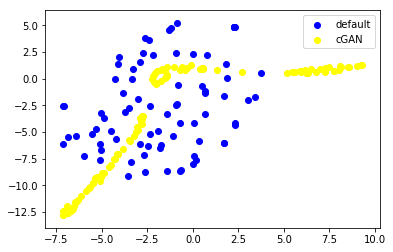

epoch = 327/1000, d_loss=0.595, g_loss=1.064                                                                                                                    
epoch = 328/1000, d_loss=0.572, g_loss=1.078                                                                                                                    
epoch = 329/1000, d_loss=0.527, g_loss=1.077                                                                                                                    
epoch = 330/1000, d_loss=0.577, g_loss=1.477                                                                                                                    
epoch = 331/1000, d_loss=0.546, g_loss=1.146                                                                                                                    
epoch = 332/1000, d_loss=0.594, g_loss=1.319                                                                                                                    
epoch = 333/1000, d_loss=0.594, g_

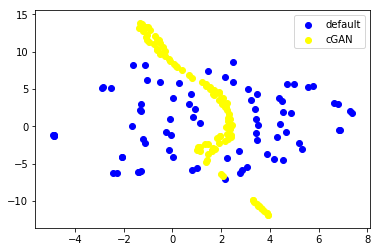

epoch = 352/1000, d_loss=0.574, g_loss=1.513                                                                                                                    
epoch = 353/1000, d_loss=0.530, g_loss=2.328                                                                                                                    
epoch = 354/1000, d_loss=0.604, g_loss=1.169                                                                                                                    
epoch = 355/1000, d_loss=0.544, g_loss=1.138                                                                                                                    
epoch = 356/1000, d_loss=0.529, g_loss=1.676                                                                                                                                                                                                                        
epoch = 357/1000, d_loss=0.549, g_loss=1.777                                                   

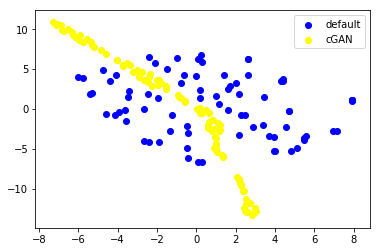

epoch = 377/1000, d_loss=0.514, g_loss=2.391                                                                                                                    
epoch = 378/1000, d_loss=0.562, g_loss=0.835                                                                                                                    
epoch = 379/1000, d_loss=0.608, g_loss=1.502                                                                                                                    
epoch = 380/1000, d_loss=0.574, g_loss=2.698                                                                                                                    
epoch = 381/1000, d_loss=0.573, g_loss=1.535                                                                                                                    
epoch = 382/1000, d_loss=0.538, g_loss=1.208                                                                                                                    
epoch = 383/1000, d_loss=0.556, g_

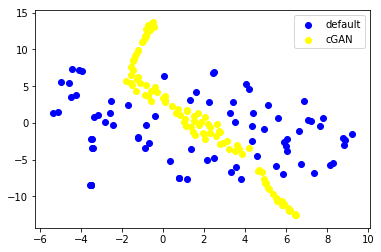

epoch = 402/1000, d_loss=0.552, g_loss=2.185                                                                                                                    
epoch = 403/1000, d_loss=0.542, g_loss=2.977                                                                                                                    
epoch = 404/1000, d_loss=0.521, g_loss=1.729                                                                                                                    
epoch = 405/1000, d_loss=0.508, g_loss=2.249                                                                                                                    
epoch = 406/1000, d_loss=0.549, g_loss=1.904                                                                                                                    
epoch = 407/1000, d_loss=0.520, g_loss=3.301                                                                                                                    
epoch = 408/1000, d_loss=0.527, g_

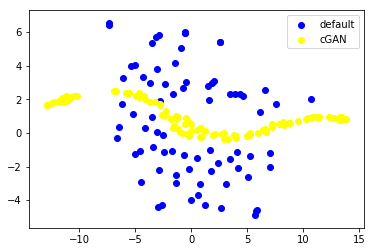

epoch = 427/1000, d_loss=0.537, g_loss=1.332                                                                                                                    
epoch = 428/1000, d_loss=0.520, g_loss=1.962                                                                                                                    
epoch = 429/1000, d_loss=0.541, g_loss=1.876                                                                                                                    
epoch = 430/1000, d_loss=0.580, g_loss=1.759                                                                                                                    
epoch = 431/1000, d_loss=0.549, g_loss=3.630                                                                                                                    
epoch = 432/1000, d_loss=0.545, g_loss=1.812                                                                                                                    
epoch = 433/1000, d_loss=0.501, g_

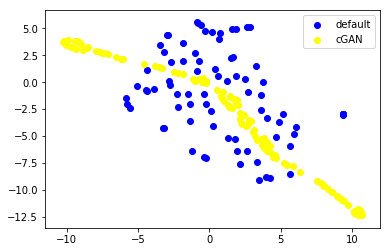

epoch = 452/1000, d_loss=0.489, g_loss=3.705                                                                                                                    
epoch = 453/1000, d_loss=0.523, g_loss=2.605                                                                                                                    
epoch = 454/1000, d_loss=0.494, g_loss=2.660                                                                                                                    
epoch = 455/1000, d_loss=0.467, g_loss=2.540                                                                                                                    
epoch = 456/1000, d_loss=0.467, g_loss=2.115                                                                                                                    
epoch = 457/1000, d_loss=0.509, g_loss=3.305                                                                                                                    
epoch = 458/1000, d_loss=0.553, g_

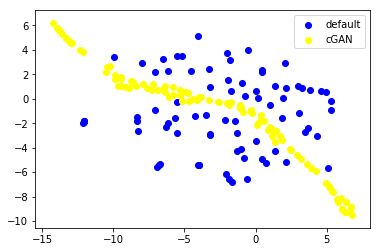

epoch = 477/1000, d_loss=0.530, g_loss=2.839                                                                                                                    
epoch = 478/1000, d_loss=0.542, g_loss=2.157                                                                                                                    
epoch = 479/1000, d_loss=0.526, g_loss=2.239                                                                                                                    
epoch = 480/1000, d_loss=0.520, g_loss=2.368                                                                                                                    
epoch = 481/1000, d_loss=0.567, g_loss=2.150                                                                                                                    
epoch = 482/1000, d_loss=0.500, g_loss=3.376                                                                                                                    
epoch = 483/1000, d_loss=0.455, g_

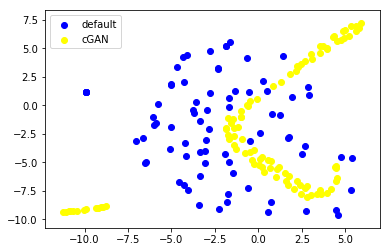

epoch = 502/1000, d_loss=0.519, g_loss=2.637                                                                                                                    
epoch = 503/1000, d_loss=0.490, g_loss=2.047                                                                                                                    
epoch = 504/1000, d_loss=0.550, g_loss=5.100                                                                                                                    
epoch = 505/1000, d_loss=0.475, g_loss=3.007                                                                                                                    
epoch = 506/1000, d_loss=0.510, g_loss=2.599                                                                                                                    
epoch = 507/1000, d_loss=0.560, g_loss=3.870                                                                                                                    
epoch = 508/1000, d_loss=0.566, g_

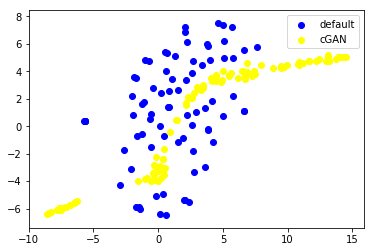

epoch = 527/1000, d_loss=0.638, g_loss=4.207                                                                                                                    
epoch = 528/1000, d_loss=0.585, g_loss=2.536                                                                                                                    
epoch = 529/1000, d_loss=0.508, g_loss=3.844                                                                                                                    
epoch = 530/1000, d_loss=0.485, g_loss=1.459                                                                                                                    
epoch = 531/1000, d_loss=0.506, g_loss=2.023                                                                                                                    
epoch = 532/1000, d_loss=0.541, g_loss=2.948                                                                                                                    
epoch = 533/1000, d_loss=0.533, g_

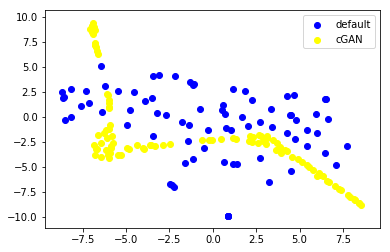

epoch = 552/1000, d_loss=0.510, g_loss=1.807                                                                                                                    
epoch = 553/1000, d_loss=0.526, g_loss=4.950                                                                                                                    
epoch = 554/1000, d_loss=0.602, g_loss=5.801                                                                                                                    
epoch = 555/1000, d_loss=0.509, g_loss=2.682                                                                                                                    
epoch = 556/1000, d_loss=0.537, g_loss=2.546                                                                                                                    
epoch = 557/1000, d_loss=0.533, g_loss=2.973                                                                                                                    
epoch = 558/1000, d_loss=0.497, g_

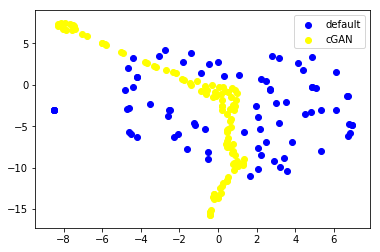

epoch = 577/1000, d_loss=0.536, g_loss=2.741                                                                                                                    
epoch = 578/1000, d_loss=0.525, g_loss=2.593                                                                                                                    
epoch = 579/1000, d_loss=0.458, g_loss=2.703                                                                                                                    
epoch = 580/1000, d_loss=0.494, g_loss=2.927                                                                                                                    
epoch = 581/1000, d_loss=0.547, g_loss=2.983                                                                                                                    
epoch = 582/1000, d_loss=0.554, g_loss=3.460                                                                                                                    
epoch = 583/1000, d_loss=0.531, g_

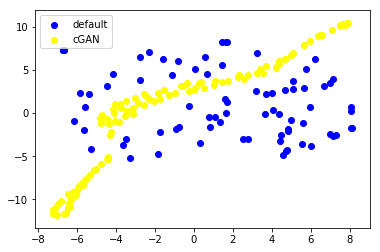

epoch = 602/1000, d_loss=0.521, g_loss=2.379                                                                                                                    
epoch = 603/1000, d_loss=0.583, g_loss=2.292                                                                                                                    
epoch = 604/1000, d_loss=0.569, g_loss=4.899                                                                                                                    
epoch = 605/1000, d_loss=0.544, g_loss=2.734                                                                                                                    
epoch = 606/1000, d_loss=0.436, g_loss=2.528                                                                                                                    
epoch = 607/1000, d_loss=0.519, g_loss=2.616                                                                                                                    
epoch = 608/1000, d_loss=0.533, g_

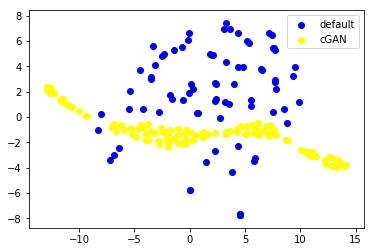

epoch = 627/1000, d_loss=0.522, g_loss=3.043                                                                                                                    
epoch = 628/1000, d_loss=0.535, g_loss=3.256                                                                                                                    
epoch = 629/1000, d_loss=0.466, g_loss=3.977                                                                                                                    
epoch = 630/1000, d_loss=0.526, g_loss=2.993                                                                                                                    
epoch = 631/1000, d_loss=0.525, g_loss=3.149                                                                                                                    
epoch = 632/1000, d_loss=0.501, g_loss=4.871                                                                                                                                                       

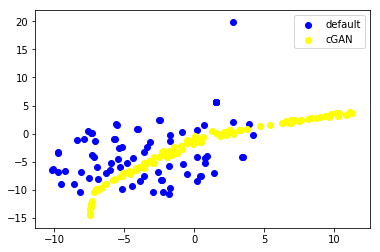

epoch = 652/1000, d_loss=0.508, g_loss=3.138                                                                                                                    
epoch = 653/1000, d_loss=0.484, g_loss=3.811                                                                                                                    
epoch = 654/1000, d_loss=0.520, g_loss=2.657                                                                                                                    
epoch = 655/1000, d_loss=0.535, g_loss=3.061                                                                                                                    
epoch = 656/1000, d_loss=0.514, g_loss=2.428                                                                                                                    
epoch = 657/1000, d_loss=0.515, g_loss=3.174                                                                                                                    
epoch = 658/1000, d_loss=0.527, g_

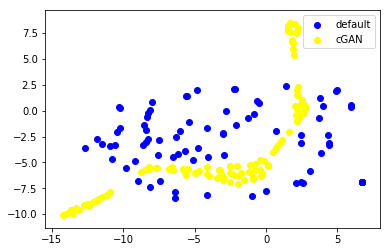

epoch = 677/1000, d_loss=0.483, g_loss=5.049                                                                                                                    
epoch = 678/1000, d_loss=0.559, g_loss=3.068                                                                                                                    
epoch = 679/1000, d_loss=0.548, g_loss=4.533                                                                                                                    
epoch = 680/1000, d_loss=0.476, g_loss=4.560                                                                                                                    
epoch = 681/1000, d_loss=0.516, g_loss=3.610                                                                                                                    
epoch = 682/1000, d_loss=0.479, g_loss=3.958                                                                                                                    
epoch = 683/1000, d_loss=0.506, g_

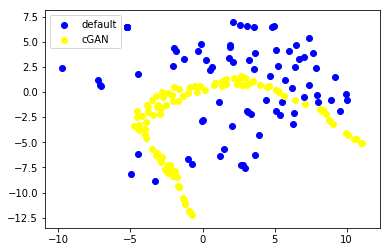

epoch = 702/1000, d_loss=0.518, g_loss=3.031                                                                                                                    
epoch = 703/1000, d_loss=0.455, g_loss=4.634                                                                                                                    
epoch = 704/1000, d_loss=0.540, g_loss=3.434                                                                                                                    
epoch = 705/1000, d_loss=0.453, g_loss=2.717                                                                                                                    
epoch = 706/1000, d_loss=0.490, g_loss=3.331                                                                                                                    
epoch = 707/1000, d_loss=0.504, g_loss=3.748                                                                                                                    
epoch = 708/1000, d_loss=0.590, g_

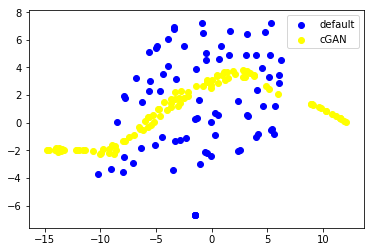

epoch = 727/1000, d_loss=0.497, g_loss=3.243                                                                                                                    
epoch = 728/1000, d_loss=0.547, g_loss=3.211                                                                                                                                                                                                                        
epoch = 729/1000, d_loss=0.504, g_loss=3.675                                                                                                                    
epoch = 730/1000, d_loss=0.487, g_loss=2.715                                                                                                                    
epoch = 731/1000, d_loss=0.481, g_loss=4.406                                                                                                                    
epoch = 732/1000, d_loss=0.497, g_loss=2.201                                                   

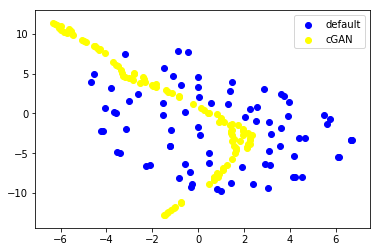

epoch = 752/1000, d_loss=0.521, g_loss=2.668                                                                                                                    
epoch = 753/1000, d_loss=0.542, g_loss=2.729                                                                                                                    
epoch = 754/1000, d_loss=0.526, g_loss=2.597                                                                                                                                                                                                                         
epoch = 755/1000, d_loss=0.587, g_loss=3.052                                                                                                                    
epoch = 756/1000, d_loss=0.526, g_loss=4.034                                                                                                                    
epoch = 757/1000, d_loss=0.530, g_loss=3.802                                                  

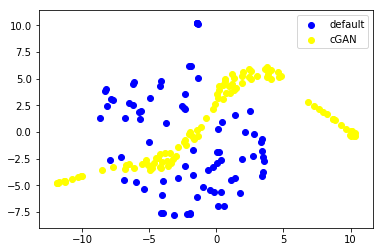

epoch = 777/1000, d_loss=0.542, g_loss=3.725                                                                                                                    
epoch = 778/1000, d_loss=0.488, g_loss=2.725                                                                                                                    
epoch = 779/1000, d_loss=0.524, g_loss=4.326                                                                                                                    
epoch = 780/1000, d_loss=0.575, g_loss=3.696                                                                                                                    
epoch = 781/1000, d_loss=0.479, g_loss=3.947                                                                                                                    
epoch = 782/1000, d_loss=0.589, g_loss=3.711                                                                                                                    
epoch = 783/1000, d_loss=0.546, g_

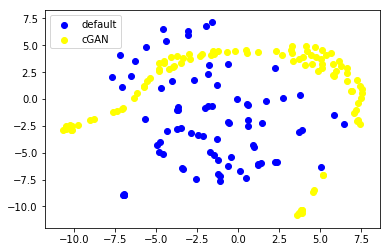

epoch = 802/1000, d_loss=0.538, g_loss=4.492                                                                                                                    
epoch = 803/1000, d_loss=0.469, g_loss=3.756                                                                                                                    
epoch = 804/1000, d_loss=0.550, g_loss=3.417                                                                                                                    
epoch = 805/1000, d_loss=0.545, g_loss=3.245                                                                                                                    
epoch = 806/1000, d_loss=0.505, g_loss=3.251                                                                                                                    
epoch = 807/1000, d_loss=0.529, g_loss=2.800                                                                                                                    
epoch = 808/1000, d_loss=0.517, g_

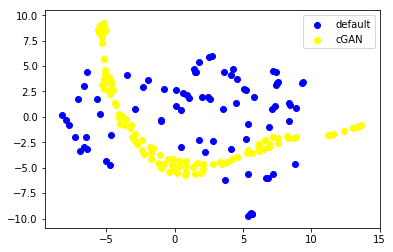

epoch = 827/1000, d_loss=0.468, g_loss=4.710                                                                                                                    
epoch = 828/1000, d_loss=0.524, g_loss=4.107                                                                                                                    
epoch = 829/1000, d_loss=0.448, g_loss=4.675                                                                                                                    
epoch = 830/1000, d_loss=0.520, g_loss=2.866                                                                                                                    
epoch = 831/1000, d_loss=0.463, g_loss=4.264                                                                                                                    
epoch = 832/1000, d_loss=0.513, g_loss=3.701                                                                                                                    
epoch = 833/1000, d_loss=0.528, g_

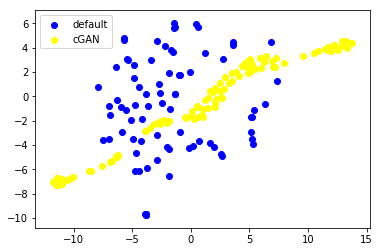

epoch = 852/1000, d_loss=0.522, g_loss=3.823                                                                                                                    
epoch = 853/1000, d_loss=0.437, g_loss=4.378                                                                                                                    
epoch = 854/1000, d_loss=0.493, g_loss=3.830                                                                                                                    
epoch = 855/1000, d_loss=0.536, g_loss=2.372                                                                                                                    
epoch = 856/1000, d_loss=0.512, g_loss=4.235                                                                                                                                                                                                                       
epoch = 857/1000, d_loss=0.552, g_loss=3.657                                                    

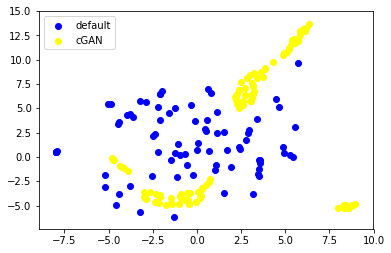

epoch = 877/1000, d_loss=0.531, g_loss=3.678                                                                                                                    
epoch = 878/1000, d_loss=0.495, g_loss=4.163                                                                                                                    
epoch = 879/1000, d_loss=0.538, g_loss=3.927                                                                                                                    
epoch = 880/1000, d_loss=0.483, g_loss=4.434                                                                                                                    
epoch = 881/1000, d_loss=0.510, g_loss=5.173                                                                                                                    
epoch = 882/1000, d_loss=0.505, g_loss=4.764                                                                                                                    
epoch = 883/1000, d_loss=0.502, g_

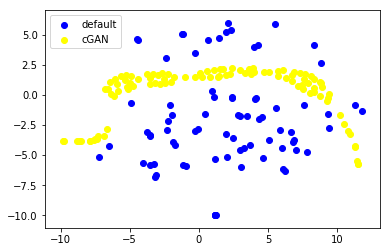

epoch = 902/1000, d_loss=0.528, g_loss=3.441                                                                                                                    
epoch = 903/1000, d_loss=0.519, g_loss=3.480                                                                                                                    
epoch = 904/1000, d_loss=0.527, g_loss=3.484                                                                                                                    
epoch = 905/1000, d_loss=0.570, g_loss=3.188                                                                                                                    
epoch = 906/1000, d_loss=0.534, g_loss=5.163                                                                                                                    
epoch = 907/1000, d_loss=0.501, g_loss=2.901                                                                                                                    
epoch = 908/1000, d_loss=0.582, g_

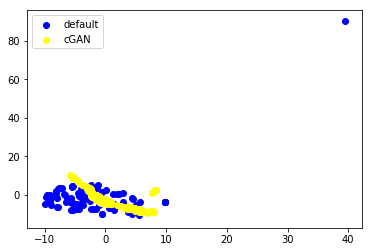

epoch = 927/1000, d_loss=0.507, g_loss=3.585                                                                                                                    
epoch = 928/1000, d_loss=0.541, g_loss=4.132                                                                                                                    
epoch = 929/1000, d_loss=0.463, g_loss=3.812                                                                                                                    
epoch = 930/1000, d_loss=0.516, g_loss=4.433                                                                                                                    
epoch = 931/1000, d_loss=0.499, g_loss=3.222                                                                                                                    
epoch = 932/1000, d_loss=0.491, g_loss=3.637                                                                                                                    
epoch = 933/1000, d_loss=0.482, g_

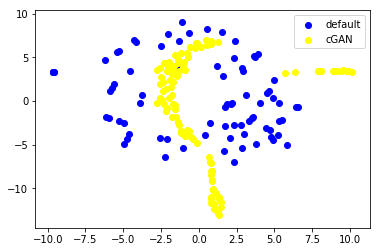

epoch = 952/1000, d_loss=0.494, g_loss=5.813                                                                                                                    
epoch = 953/1000, d_loss=0.434, g_loss=3.345                                                                                                                    
epoch = 954/1000, d_loss=0.489, g_loss=3.299                                                                                                                    
epoch = 955/1000, d_loss=0.430, g_loss=3.310                                                                                                                    
epoch = 956/1000, d_loss=0.496, g_loss=3.799                                                                                                                    
epoch = 957/1000, d_loss=0.515, g_loss=4.645                                                                                                                    
epoch = 958/1000, d_loss=0.537, g_

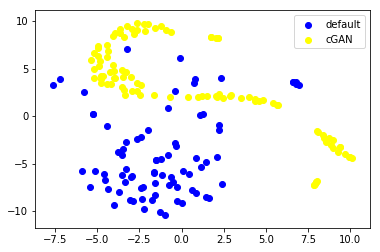

epoch = 977/1000, d_loss=0.559, g_loss=4.100                                                                                                                    
epoch = 978/1000, d_loss=0.504, g_loss=3.958                                                                                                                    
epoch = 979/1000, d_loss=0.539, g_loss=3.251                                                                                                                    
epoch = 980/1000, d_loss=0.474, g_loss=3.584                                                                                                                    
epoch = 981/1000, d_loss=0.475, g_loss=4.399                                                                                                                    
epoch = 982/1000, d_loss=0.532, g_loss=5.010                                                                                                                    
epoch = 983/1000, d_loss=0.488, g_

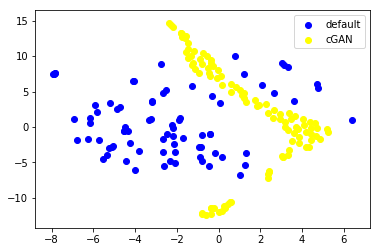

In [3]:
for e in range(epochs + 1):
    for i in range(len(np_X_train) // batch_size):
        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_batch = np_X_train[i * batch_size:(i + 1) * batch_size]
        real_labels = np_y_train[i * batch_size:(i + 1) * batch_size].reshape(-1, 1)
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))

        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.choice([-1,1], batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])

        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False

        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.choice([-1,1], batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (
            e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100 * ' ',
            end='\r'
        )

    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100 * ' ')
    if e % 25 == 0:
        samples = 100
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.random.choice([1],samples).reshape(-1, 1)
        x_fake = generator.predict([z, labels])
        x_fake = pd.DataFrame(x_fake)
        X_y_PCA = pd.concat([df_X_train_after_PCA,y_train],axis=1)
        X_y_fake = pd.concat([x_fake,fake_y_train_df],axis=1)
        X_y_PCA = X_y_PCA.values
        X_y_except = []
        for i in X_y_PCA:
                for j in i:
                    if j==1:
                        X_y_except.append(i)
        X_y_except = pd.DataFrame(X_y_except)
        X_y_fake = X_y_fake.values
        X_y_fake = pd.DataFrame(X_y_fake)
        X_y_concat = pd.concat([X_y_except,X_y_fake],axis=0)
        X_y_concat.to_csv("csvdirectory/csv%d.csv"%e)
        df1 = X_y_concat.iloc[:,0:76]
        df2 = list(X_y_concat.iloc[:,-1])
        X_embedded = tsneEmbedded.fit_transform(df1)
        xs = X_embedded[:,0]
        ys = X_embedded[:,1]
        fig = plt.gcf()
        cntb = True
        cntg = True
        for i in range(len(xs)):
            if df2[i]== 1.0:
                if cntb==True:
                    plt.scatter(xs[i],ys[i],label="default",c="blue")
                    cntb = False
                else:
                    plt.scatter(xs[i],ys[i],c="blue")
            elif df2[i]==2.0:
                if cntg ==True:
                    plt.scatter(xs[i],ys[i],label="cGAN",c="yellow")
                    cntg = False
                else:
                    plt.scatter(xs[i],ys[i],c="yellow")
        plt.legend()
        fig.savefig('csvdirectory/%dfig.png'%e)
        plt.show()

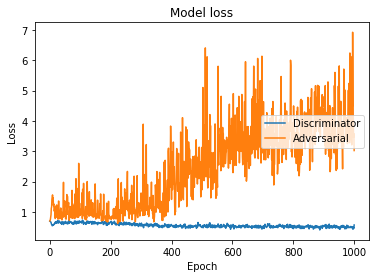

In [4]:
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()